# RRT-star Motion Planning Tutorial

We'll show rrt-star motion planning on a panda robot.

If you want to see a simulation demo, check out the examples directory.

In [1]:
import sys, os
import yaml
import trimesh
%matplotlib inline

parent_dir = os.path.dirname(os.getcwd())
pykin_path = parent_dir
sys.path.append(pykin_path)

from pykin.robots.single_arm import SingleArm
from pykin.planners.rrt_star_planner import RRTStarPlanner
from pykin.collision.collision_manager import CollisionManager
from pykin.kinematics.transform import Transform
from pykin.utils.object_utils import ObjectManager
from pykin.utils import plot_utils as plt

In [2]:
file_path = '../asset/urdf/panda/panda.urdf'
mesh_path = pykin_path+"/asset/urdf/panda/"
yaml_path = '../asset/config/panda_init_params.yaml'

with open(yaml_path) as f:
    controller_config = yaml.safe_load(f)

robot = SingleArm(file_path, Transform(rot=[0.0, 0.0, 0], pos=[0, 0, 0]))
robot.setup_link_name("panda_link_0", "panda_right_hand")

init_qpos = controller_config["init_qpos"]
init_fk = robot.forward_kin(init_qpos)
goal_eef_pose = controller_config["goal_pose"]

### Apply to robot using CollisionManager

In [3]:
c_manager = CollisionManager(mesh_path)
c_manager.setup_robot_collision(robot, init_fk)

In [4]:
milk_path = pykin_path+"/asset/objects/meshes/milk.stl"
milk_mesh = trimesh.load_mesh(milk_path)

### Apply to Object using CollisionManager

In [5]:
obs = ObjectManager()
o_manager = CollisionManager(milk_path)

In [6]:
for i in range(6):
    name = "miik_" + str(i)
    obs_pos = [0.6, -0.2+i*0.1, 0.3]

    o_manager.add_object(name, gtype="mesh", gparam=milk_mesh, h_mat=Transform(pos=obs_pos).h_mat)
    obs(name=name, gtype="mesh", gparam=milk_mesh, h_mat=Transform(pos=obs_pos).h_mat)


### Use RRTStarPlanner
- delta_distance(float): distance between nearest vertex and new vertex
- epsilon(float): 1-epsilon is probability of random sampling
- gamma_RRT_star(int): factor used for search radius
- max_iter(int): maximum number of iterations
- dimension(int): robot arm's dof
- n_step(int): for n equal divisions between waypoints

In [7]:
planner = RRTStarPlanner(
    robot=robot,
    delta_distance=0.1,
    epsilon=0.4, 
    gamma_RRT_star=0.1,
    dimension=7,
    n_step=5
)

interpolated_path : joint path divided equally by n_steps between waypoints

joint_path : actual joint path

In [8]:
interpolated_path = planner.get_path_in_joinst_space(
    cur_q=init_qpos, 
    goal_pose=goal_eef_pose,
    robot_col_manager=c_manager,
    object_col_manager=o_manager,
    max_iter=1000,
    resolution=0.3)
    
if not interpolated_path:
    print("Cannot Visulization Path")
    exit()

[INFO] [RRT Star Planner]: Start to compute RRT-star Planning


Iterators : 1000
WorkingTime[inverse_kinematics]: 0.6957 sec



[INFO] [RRT Star Planner]: iter : 300
[INFO] [RRT Star Planner]: iter : 600
[INFO] [RRT Star Planner]: iter : 900
[INFO] [RRT Star Planner]: Generate Path Successfully!!


WorkingTime[get_path_in_joinst_space]: 10.2636 sec



In [9]:
joint_trajectory = []
eef_poses = []

for step, joint in enumerate(interpolated_path):
    transformations = robot.forward_kin(joint)
    joint_trajectory.append(transformations)
    eef_poses.append(transformations[robot.eef_name].pos)

### Visualization

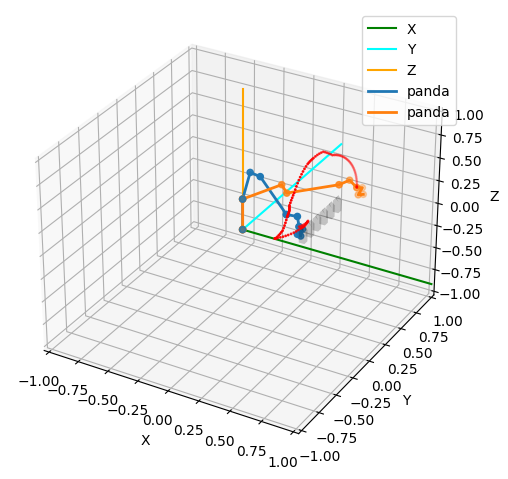

In [10]:
fig, ax = plt.init_3d_figure(figsize=(10,6), dpi= 100)

plt.plot_trajectories(ax, eef_poses, size=1)
plt.plot_robot(
    robot,
    transformations=joint_trajectory[0], 
    ax=ax,
    visible_text=False)
plt.plot_robot(
    robot, 
    transformations=joint_trajectory[-1], 
    ax=ax, 
    visible_text=False,
    visible_basis=False)
plt.plot_objects(
    ax, objects=obs, alpha=0.1
)

plt.show_figure()